## Absolute Analysis

This notebook calculates the trigger efficiency of mono-energetic muons and compares 4 different triggers. The PMT rate cut-off for low-rate and high-rate, and the adaptive trigger for low and high rate.

The notebook first estimates the single DOM rate at different PMT rates by running the 'trigger_rates.ipynb' file. The data used comes from STRAW.

The PMT rate cut-off and adaptive trigger data comes from the simulation 'sim_10tev_isotropic'.

The total detector rate was calculated by randomly selecting 200 DOMs at different rates depending on the single DOM rate distribution, and repeat 10000 times. The historgram obtained shows the fraction of time the detector is over the rate limit.

The abolute analysis is the combination of all the triggers calculated and showing the efficiency as a function of rate.


In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
from matplotlib.ticker import MultipleLocator
import random
from tqdm import tqdm

In [2]:
f = open('probabilities.pkl','rb')
probs = pkl.load(f)
f.close()
efficiency               = probs['eff']
efficiency_error         = probs['eff_error']
adaptive_probability     = probs['adaptive']
adaptive_probability_err = probs['adaptive_error']
zero                     = probs['zero']
zero_error               = probs['zero_error']

In [3]:
f = open('straw_rates.pkl','rb')
straw_rates = pkl.load(f)
f.close()
rates                    = straw_rates['rates']
cumulative_time_fraction = straw_rates['cumulative_time_fraction']
time_fraction            = straw_rates['time_fraction']

In [4]:
f = open('times_ind_low.pkl','rb')
times = pkl.load(f)
f.close()

In [5]:
%run ./trigger_rates.ipynb #self,k,rates,time_fraction,pmts=16,correlated = True
#returns rates, sdr

In [6]:
def generate_sample(cdf):
        random_number = random.random()
        for i in range(len(cdf)):
            if random_number <= cdf[i]:
                return i
def generate_tdr(nom_dom_rate,cumulative_time_fraction):
    tdr = []
    for j in tqdm(range(100000)):
        sdr = 0
        for k in range(200):
            sdr += nom_dom_rate[generate_sample(cumulative_time_fraction)]
        tdr.append(sdr)
    return tdr

## Single DOM rate estimation

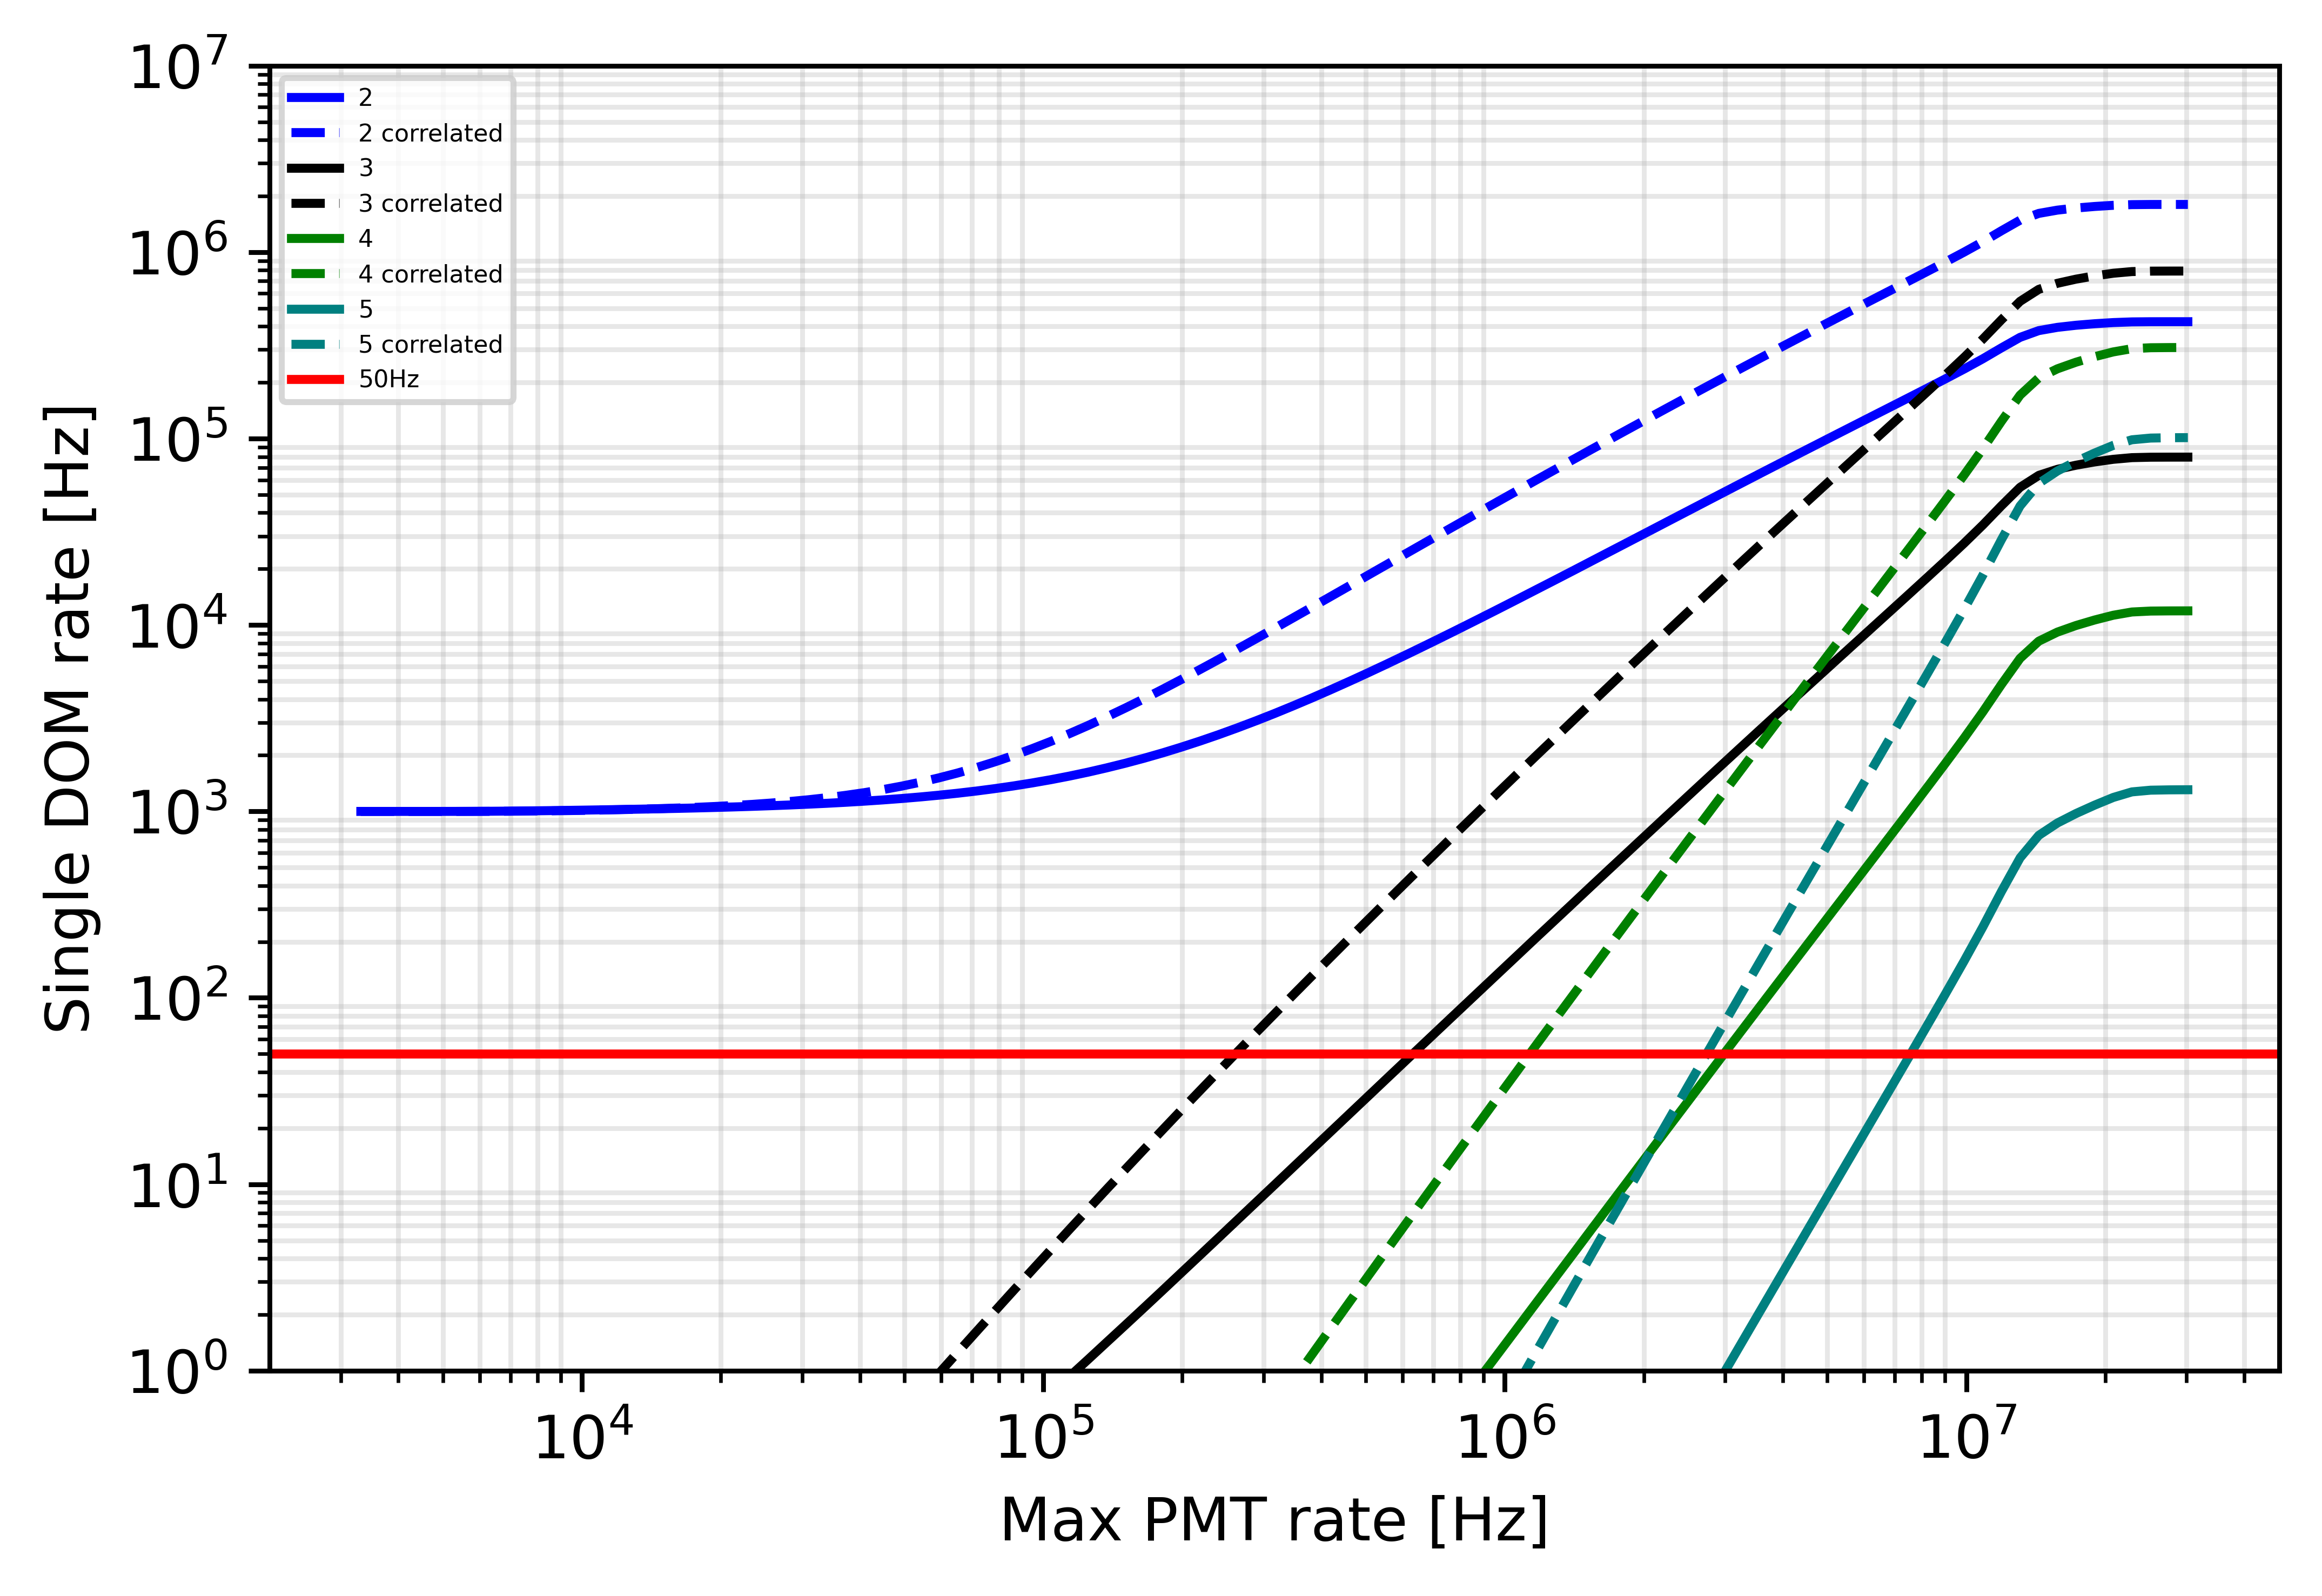

In [7]:
###TRIGGER RATES###
plt.figure(dpi=800)
colors = {5:'teal',2:'b',3:'black',4:'green'}
for n in [2,3,4,5]:
    _,sdr = trigger_rates(n,rates,time_fraction,16,True).singleDOMhalf()
    plt.plot(rates,sdr,color=colors[n],label=str(n))
    _,sdr = trigger_rates(n,rates,time_fraction,16,True).singleDOMrate()
    plt.plot(rates,sdr,'--',color=colors[n],label=str(n)+' correlated')
plt.axhline(y=50,color='r',label='50Hz')
plt.xscale('log')
plt.yscale('log')
plt.ylim([10e-1,10e6])
plt.xlabel('Max PMT rate [Hz]')
plt.ylabel('Single DOM rate [Hz]')
#plt.xlim([10e-1,10e6])
plt.legend(fontsize=4)
plt.grid()
plt.grid()
plt.grid(which='minor',alpha=0.3)

## Adaptive Trigger

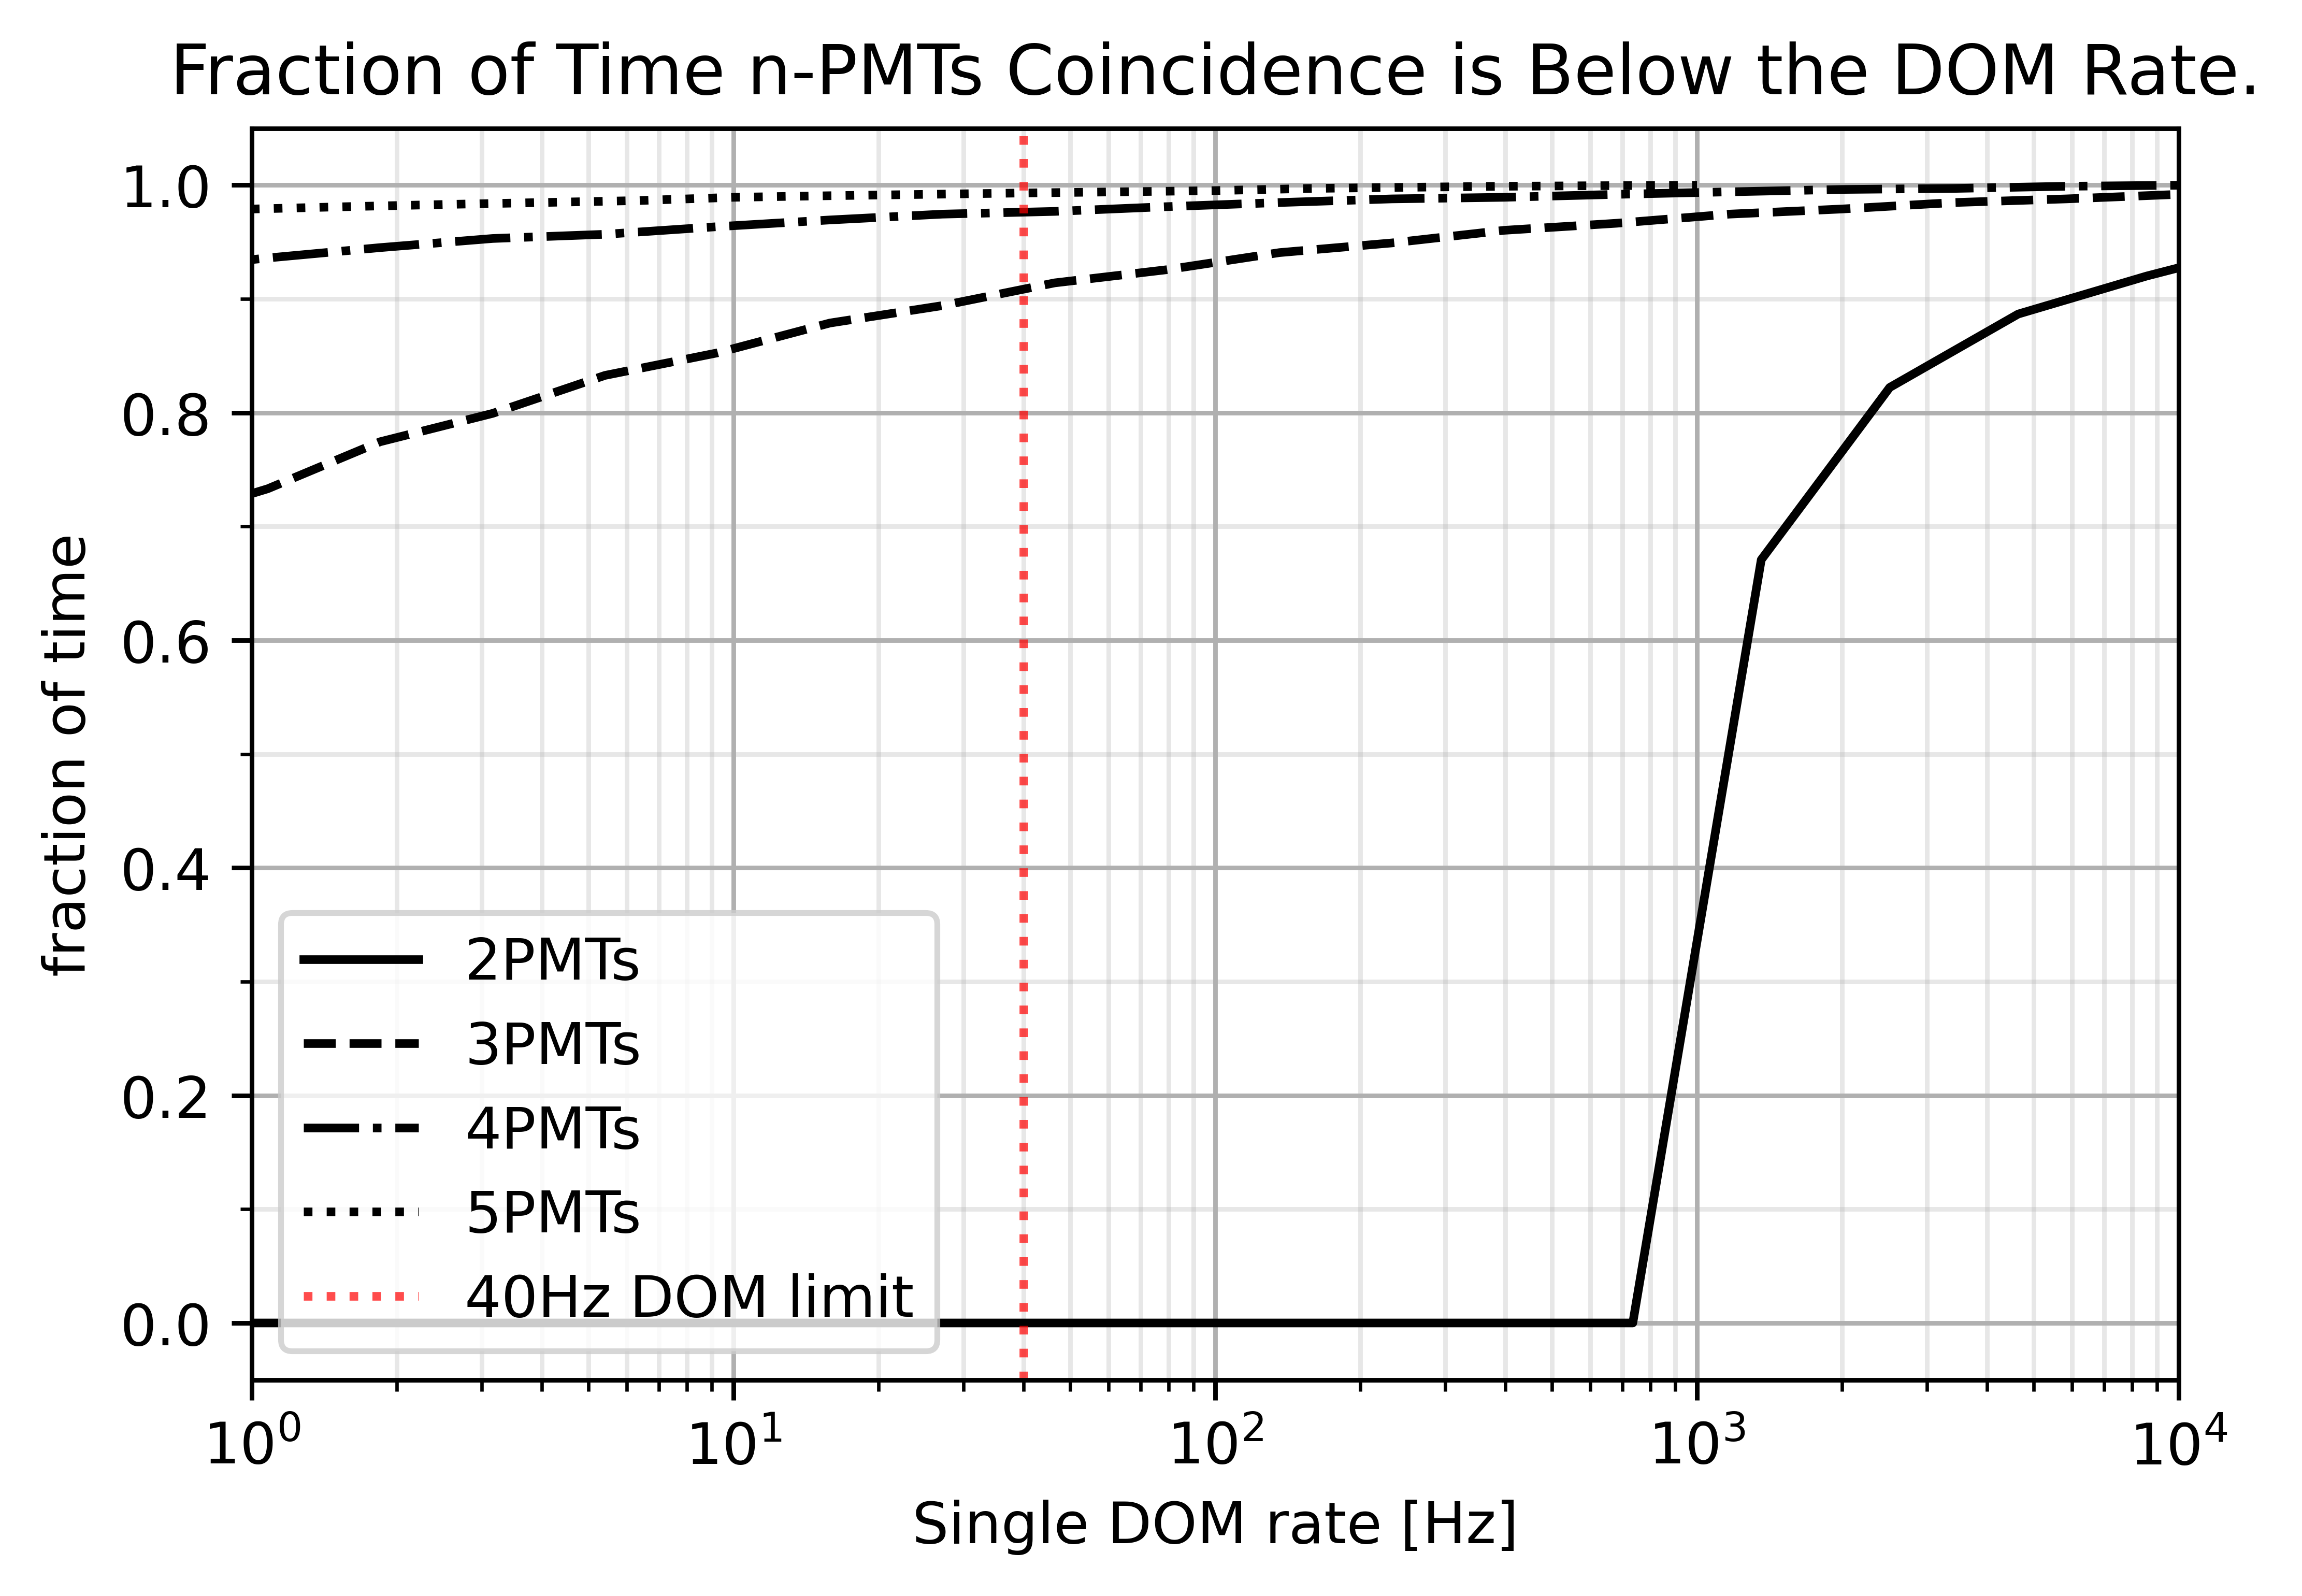

In [8]:
plt.figure(dpi = 800)
linestyles={2:'solid',3:'dashed',4:'dashdot',5:'dotted'}
for n in [2,3,4,5]:
    _,sdr = trigger_rates(n,rates,time_fraction,16,True).singleDOMhalf()
    #print(av)
    x = np.logspace(-3,int(np.log10(max(sdr))),31)
    y = []
    for i in x:
        for j in range(len(sdr)):
            if sdr[j] >= i:
                y.append(cumulative_time_fraction[j])
                break
            else:
                continue
    plt.plot(x,y,linestyle= linestyles[n],label = str(n)+'PMTs',color='black')
plt.axvline(x=40,color='r',linestyle=':',label='40Hz DOM limit',alpha=0.7)
plt.xlim([1,10e3])
plt.grid()
plt.minorticks_on()
plt.gca().yaxis.set_minor_locator(MultipleLocator(.1))
plt.grid(which='minor',alpha=0.3)
plt.legend(loc='lower left')
plt.xscale('log')
plt.ylabel('fraction of time')
plt.xlabel('Single DOM rate [Hz]')
plt.title('Fraction of Time n-PMTs Coincidence is Below the DOM Rate.')
plt.savefig('time_fraction.jpg',dpi = 800,bbox_inches='tight')

## PMT rate cut-off and Adaptive Trigger

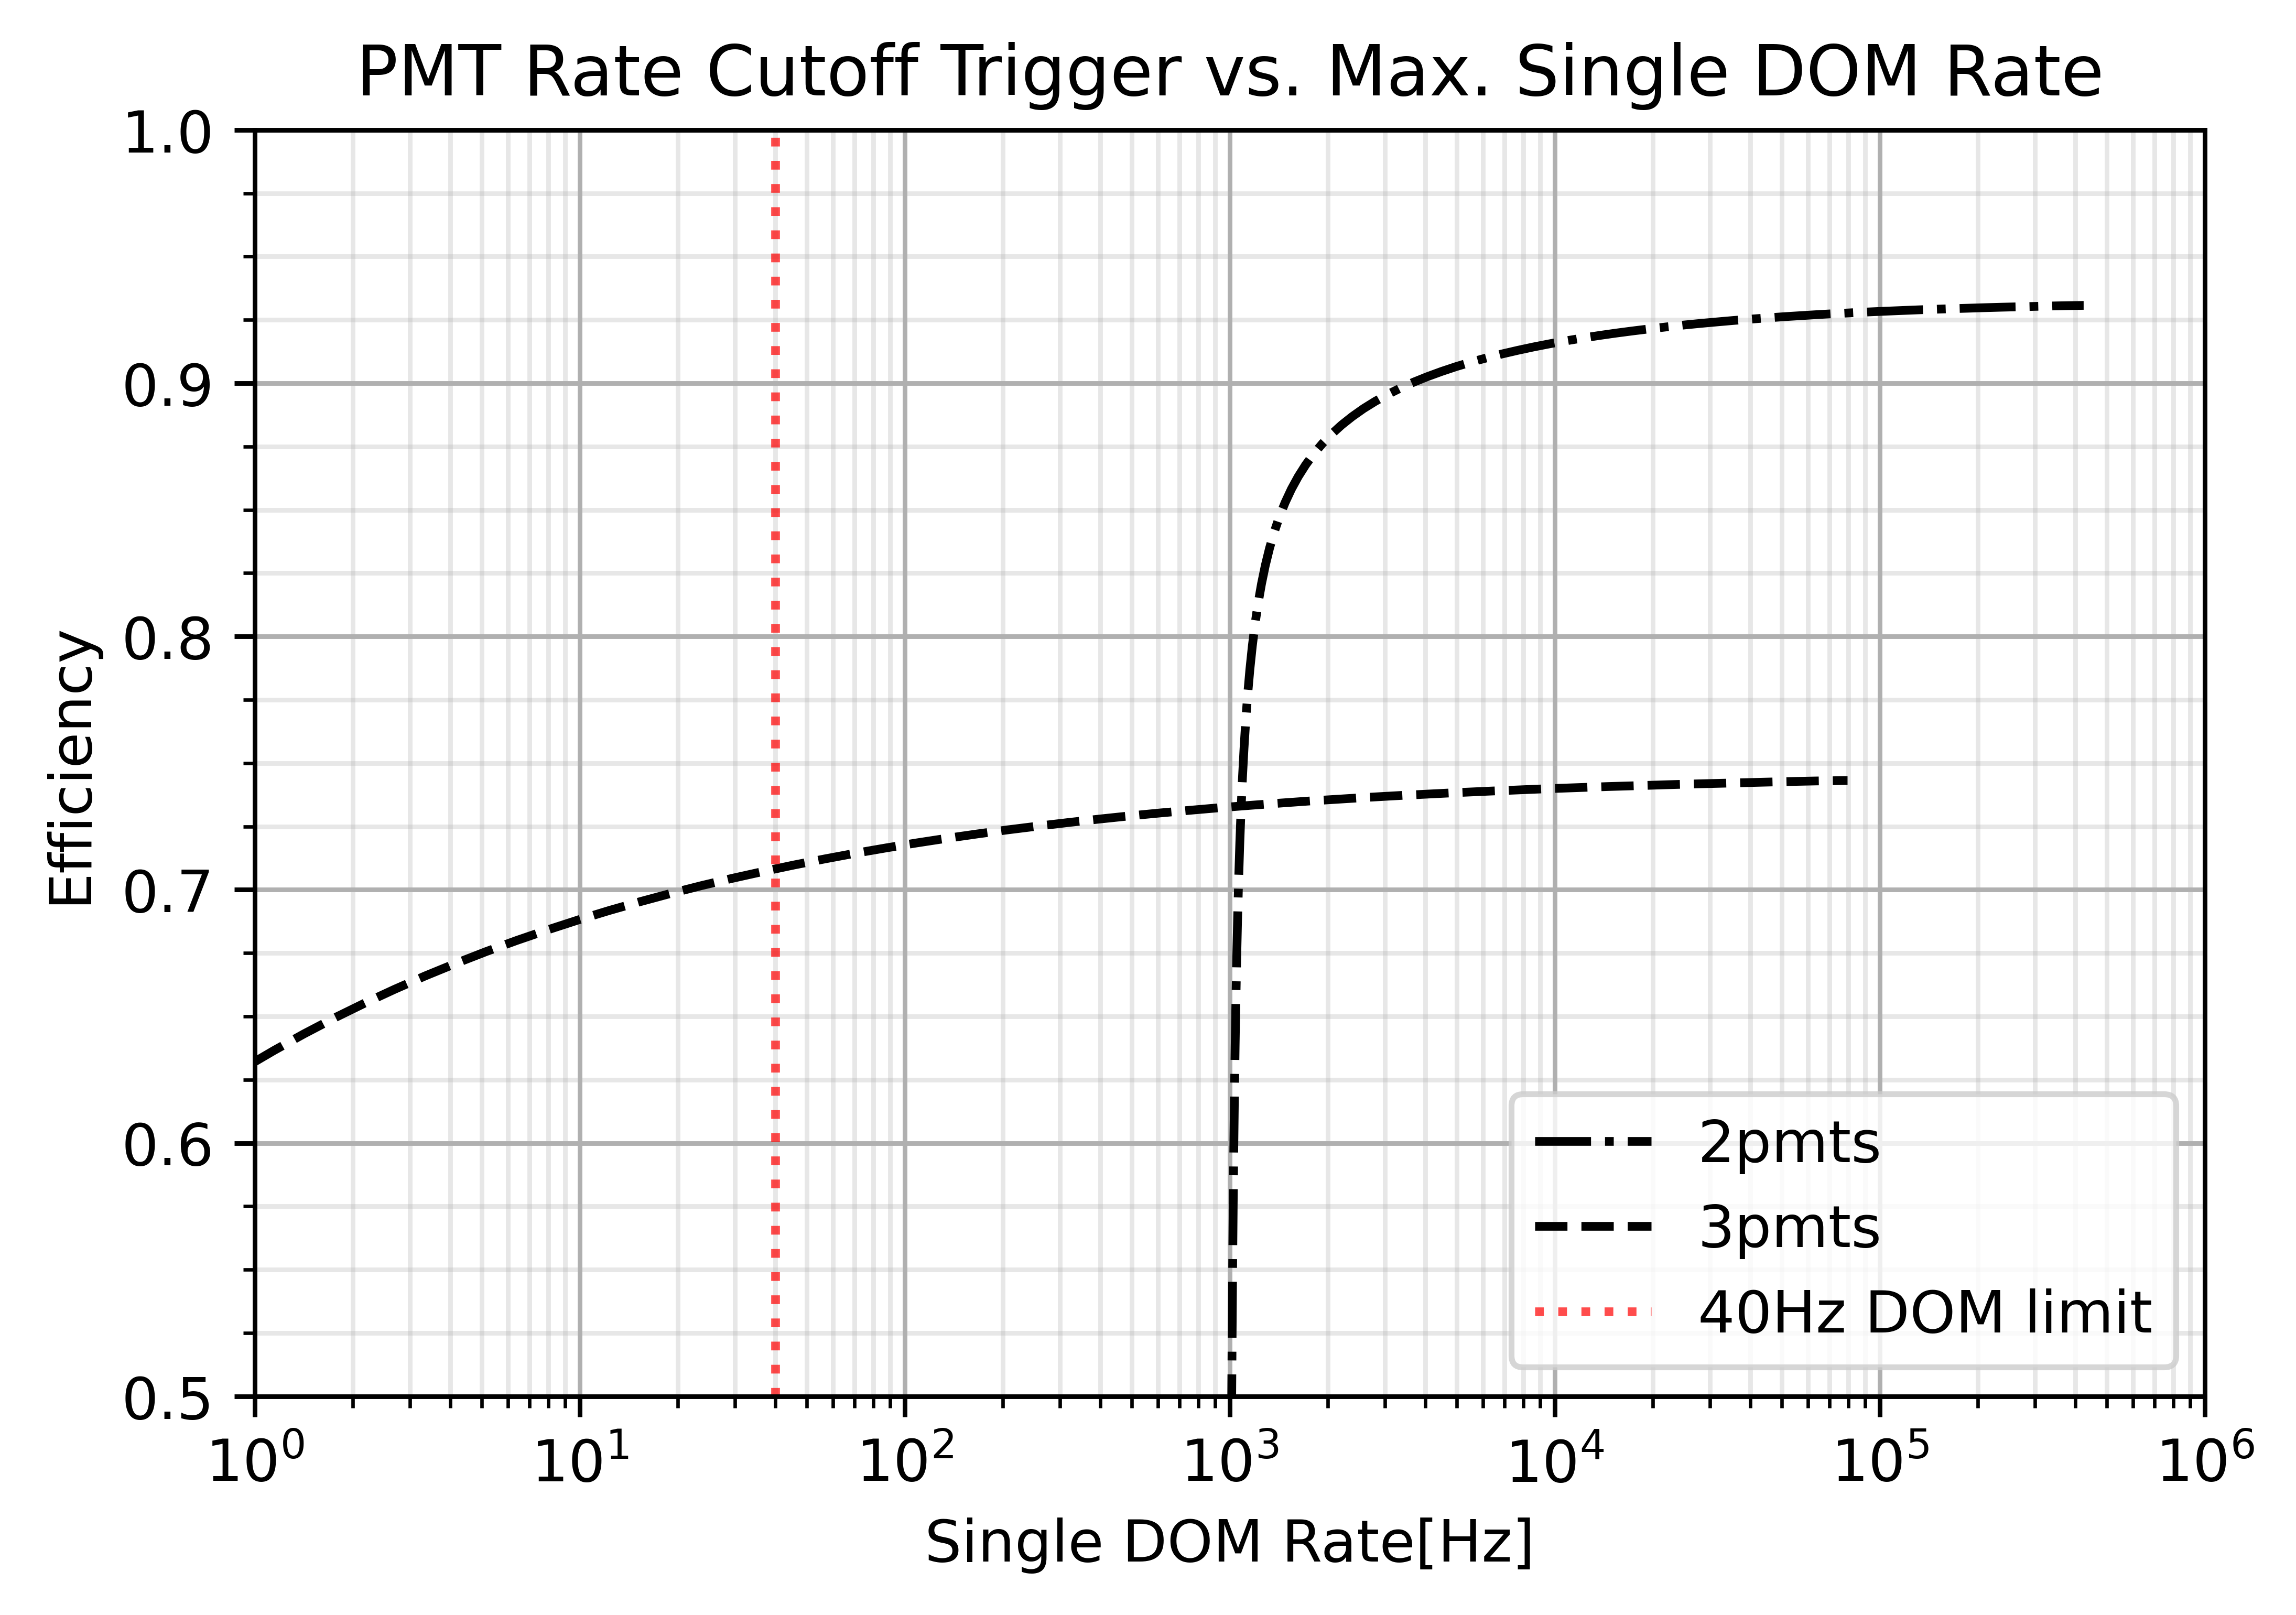

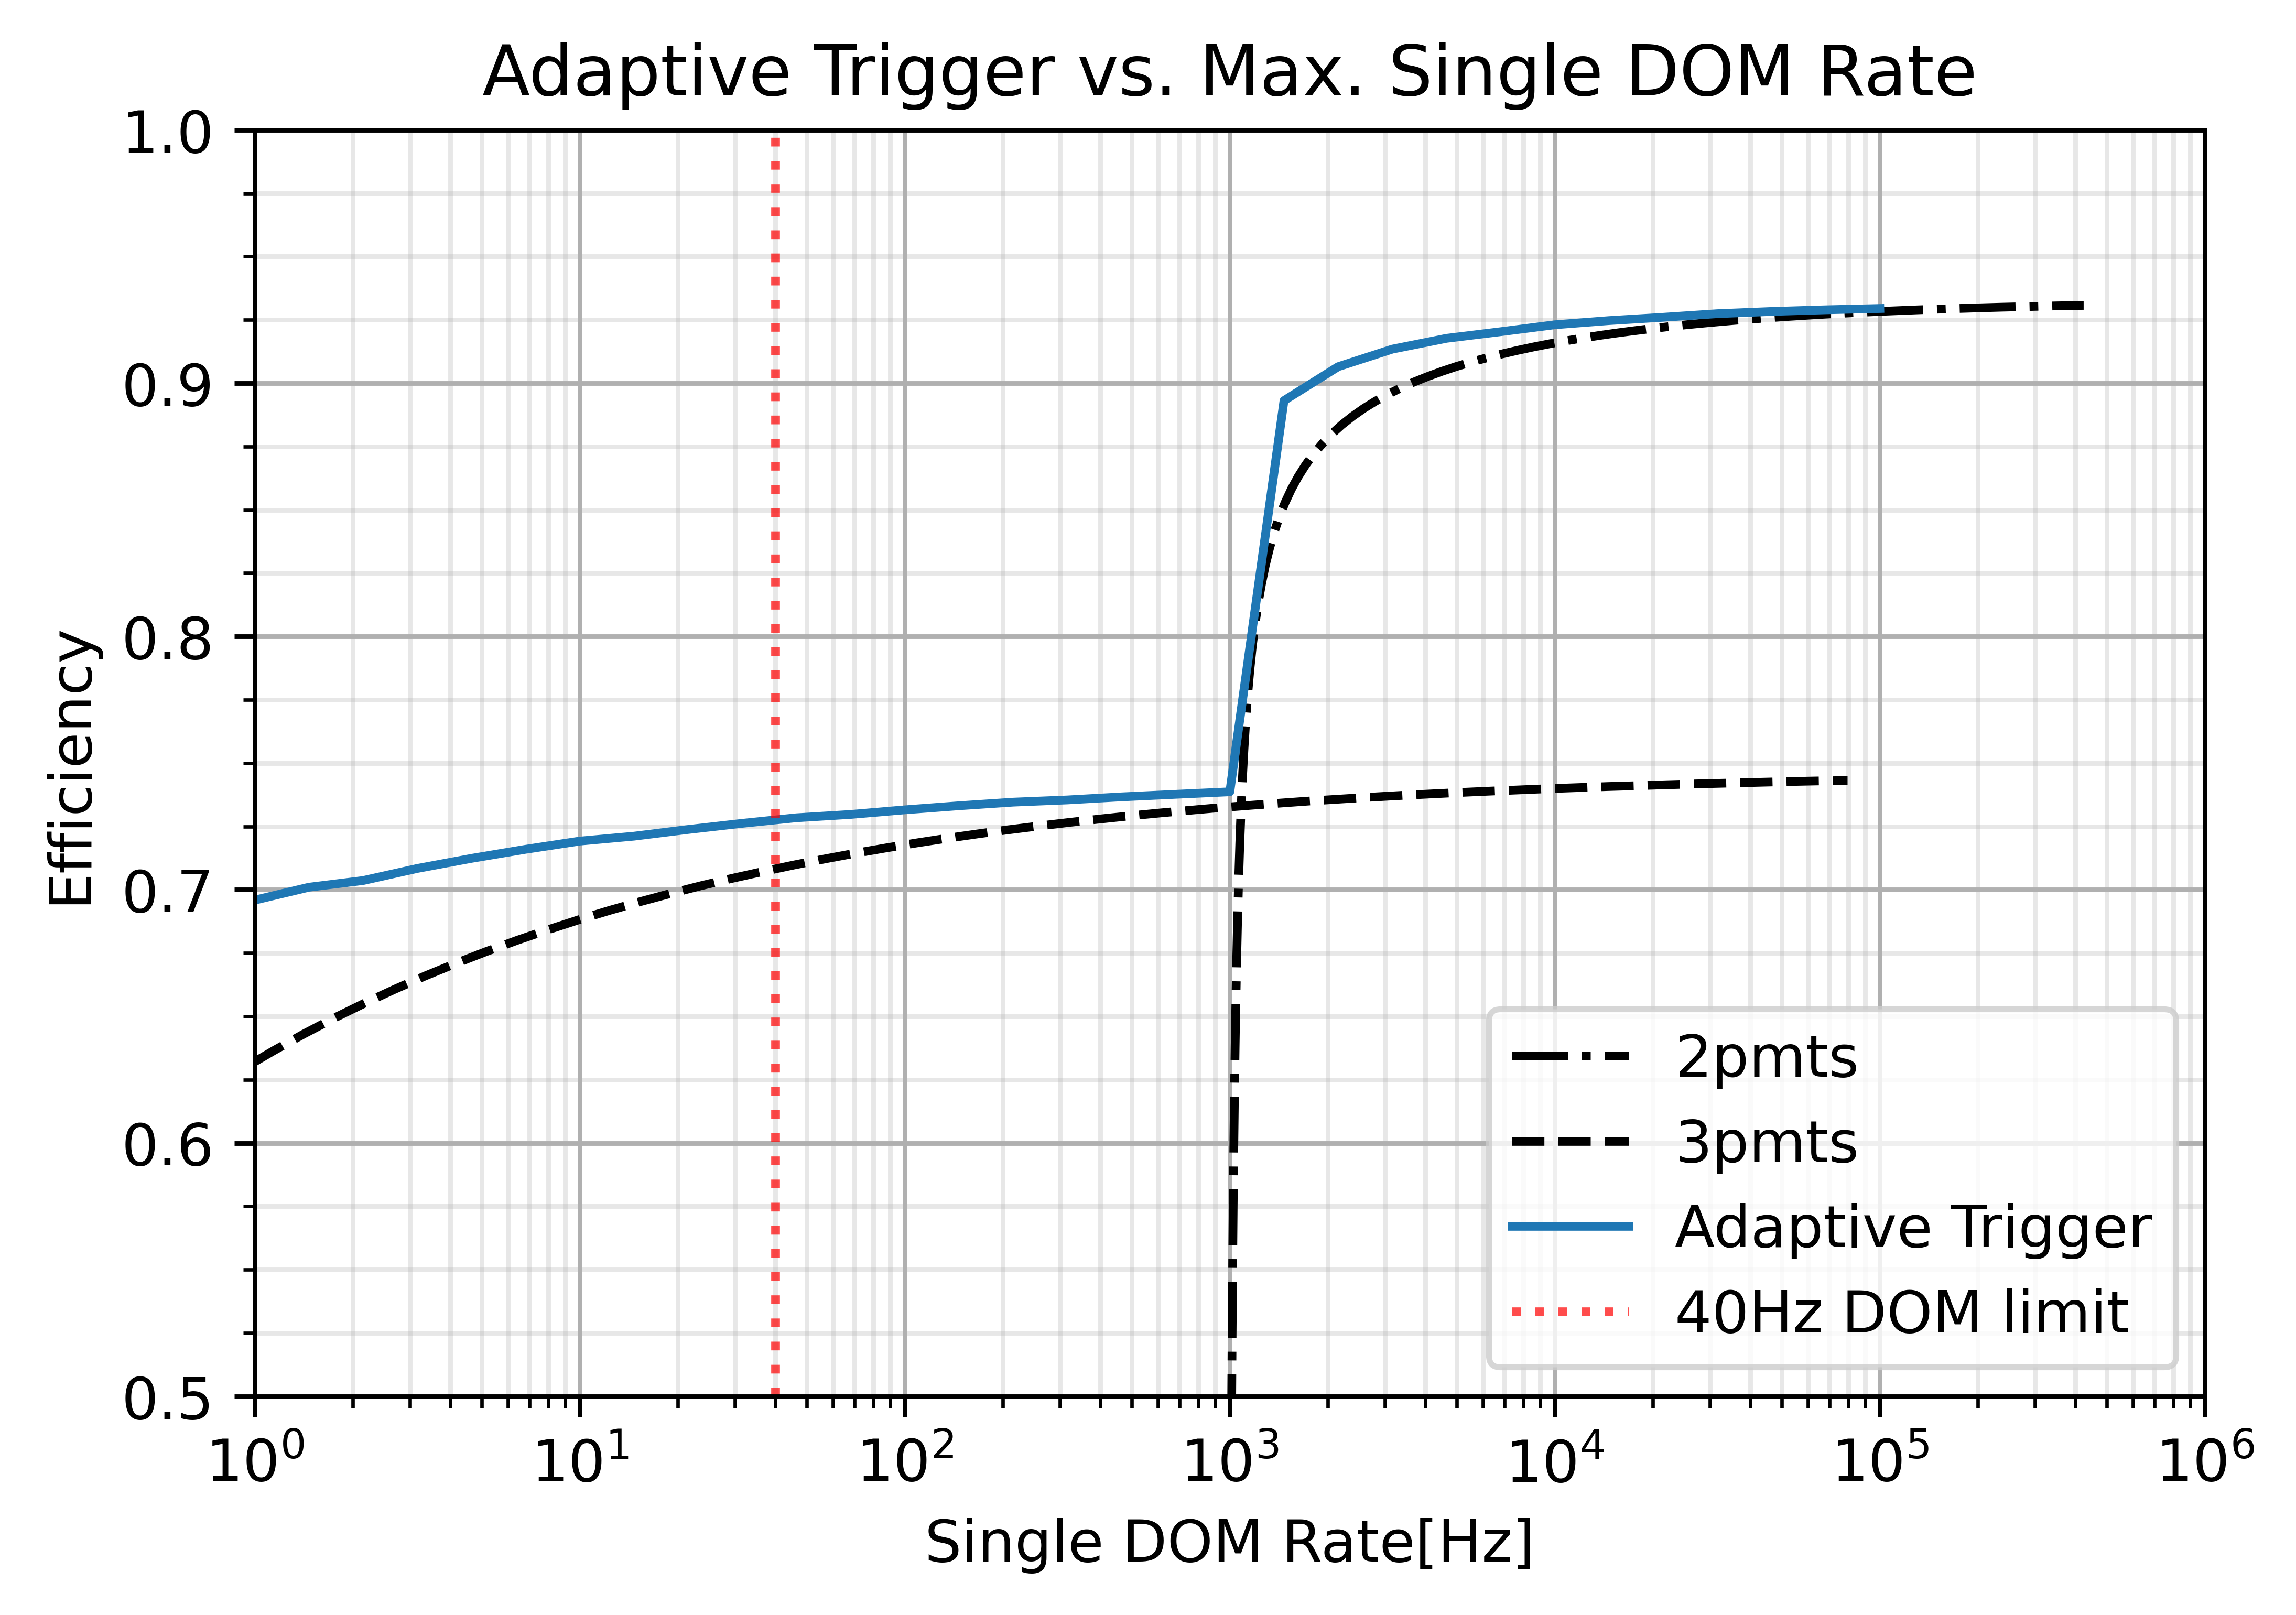

In [9]:
plt.figure(1,dpi=800)
linestyle= {2:'dashdot',3:'dashed'}
for n in [2,3]:
    _,freqs = trigger_rates(n,rates,time_fraction,16,True).singleDOMhalf()
    plt.plot(freqs,zero[n].values(),label=str(n)+'pmts',linestyle=linestyle[n],color='black')    
plt.axvline(x=40,color='r',linestyle=':',label='40Hz DOM limit',alpha=0.7)
plt.minorticks_on()
plt.gca().yaxis.set_minor_locator(MultipleLocator(.025))
plt.grid()
plt.grid(which='minor',alpha=0.3)
plt.xscale('log')
plt.ylabel('Efficiency')
plt.xlabel('Single DOM Rate[Hz]')
plt.title('PMT Rate Cutoff Trigger vs. Max. Single DOM Rate')
plt.legend()
plt.xlim([10e-1,10e5])
plt.ylim([.5,1])
plt.savefig('PMT_rate_cutoff.jpg',dpi = 800,bbox_inches='tight')
##Zero Suppressed
plt.figure(2,dpi=800)
for n in [2,3]:
    _,freqs = trigger_rates(n,rates,time_fraction,16,True).singleDOMhalf()
    plt.plot(freqs,zero[n].values(),label=str(n)+'pmts',linestyle=linestyle[n],color='black')

plt.plot(adaptive_probability.keys(),adaptive_probability.values(),linestyle='solid',label=  'Adaptive Trigger')
plt.axvline(x=40,color='r',linestyle=':',label='40Hz DOM limit',alpha=0.7)
plt.minorticks_on()
plt.gca().yaxis.set_minor_locator(MultipleLocator(.025))
plt.grid()
plt.grid(which='minor',alpha=0.3)
plt.xscale('log')
plt.ylabel('Efficiency')
plt.xlabel('Single DOM Rate[Hz]')
plt.title('Adaptive Trigger vs. Max. Single DOM Rate')
plt.legend()
plt.xlim([10e-1,10e5])
plt.ylim([.5,1])
plt.savefig('adaptive_trigger.jpg',dpi = 800,bbox_inches='tight')

## Total Detector rate estimation for low rates

In [10]:
tdr = {54:list(),55:list()}

for i in [54,55]:
    nom_dom_rate = []
    f = [j/sum(time_fraction[:i]) for j in time_fraction[:i]]
    cf = [sum(f[:j+1]) for j in range(len(f[:i]))]
    for j in rates[:i]:
        nom_dom_rate.append(trigger_rates(3,rates,time_fraction,16,True).singleDOMnominal(j))
    tdr[i] = generate_tdr(nom_dom_rate,cf)
    #x= plt.hist(tdr,bins=50,density=True)
#plt.xscale('log')

100%|██████████| 100000/100000 [00:30<00:00, 3276.85it/s]


In [11]:
tdr[54] = [i/1000 for i in tdr[54]]

In [12]:
tdr[55] = [i/1000 for i in tdr[55]]

39 0.99832 8.114756783269419
28 0.9483099999999999 8.028093735228062


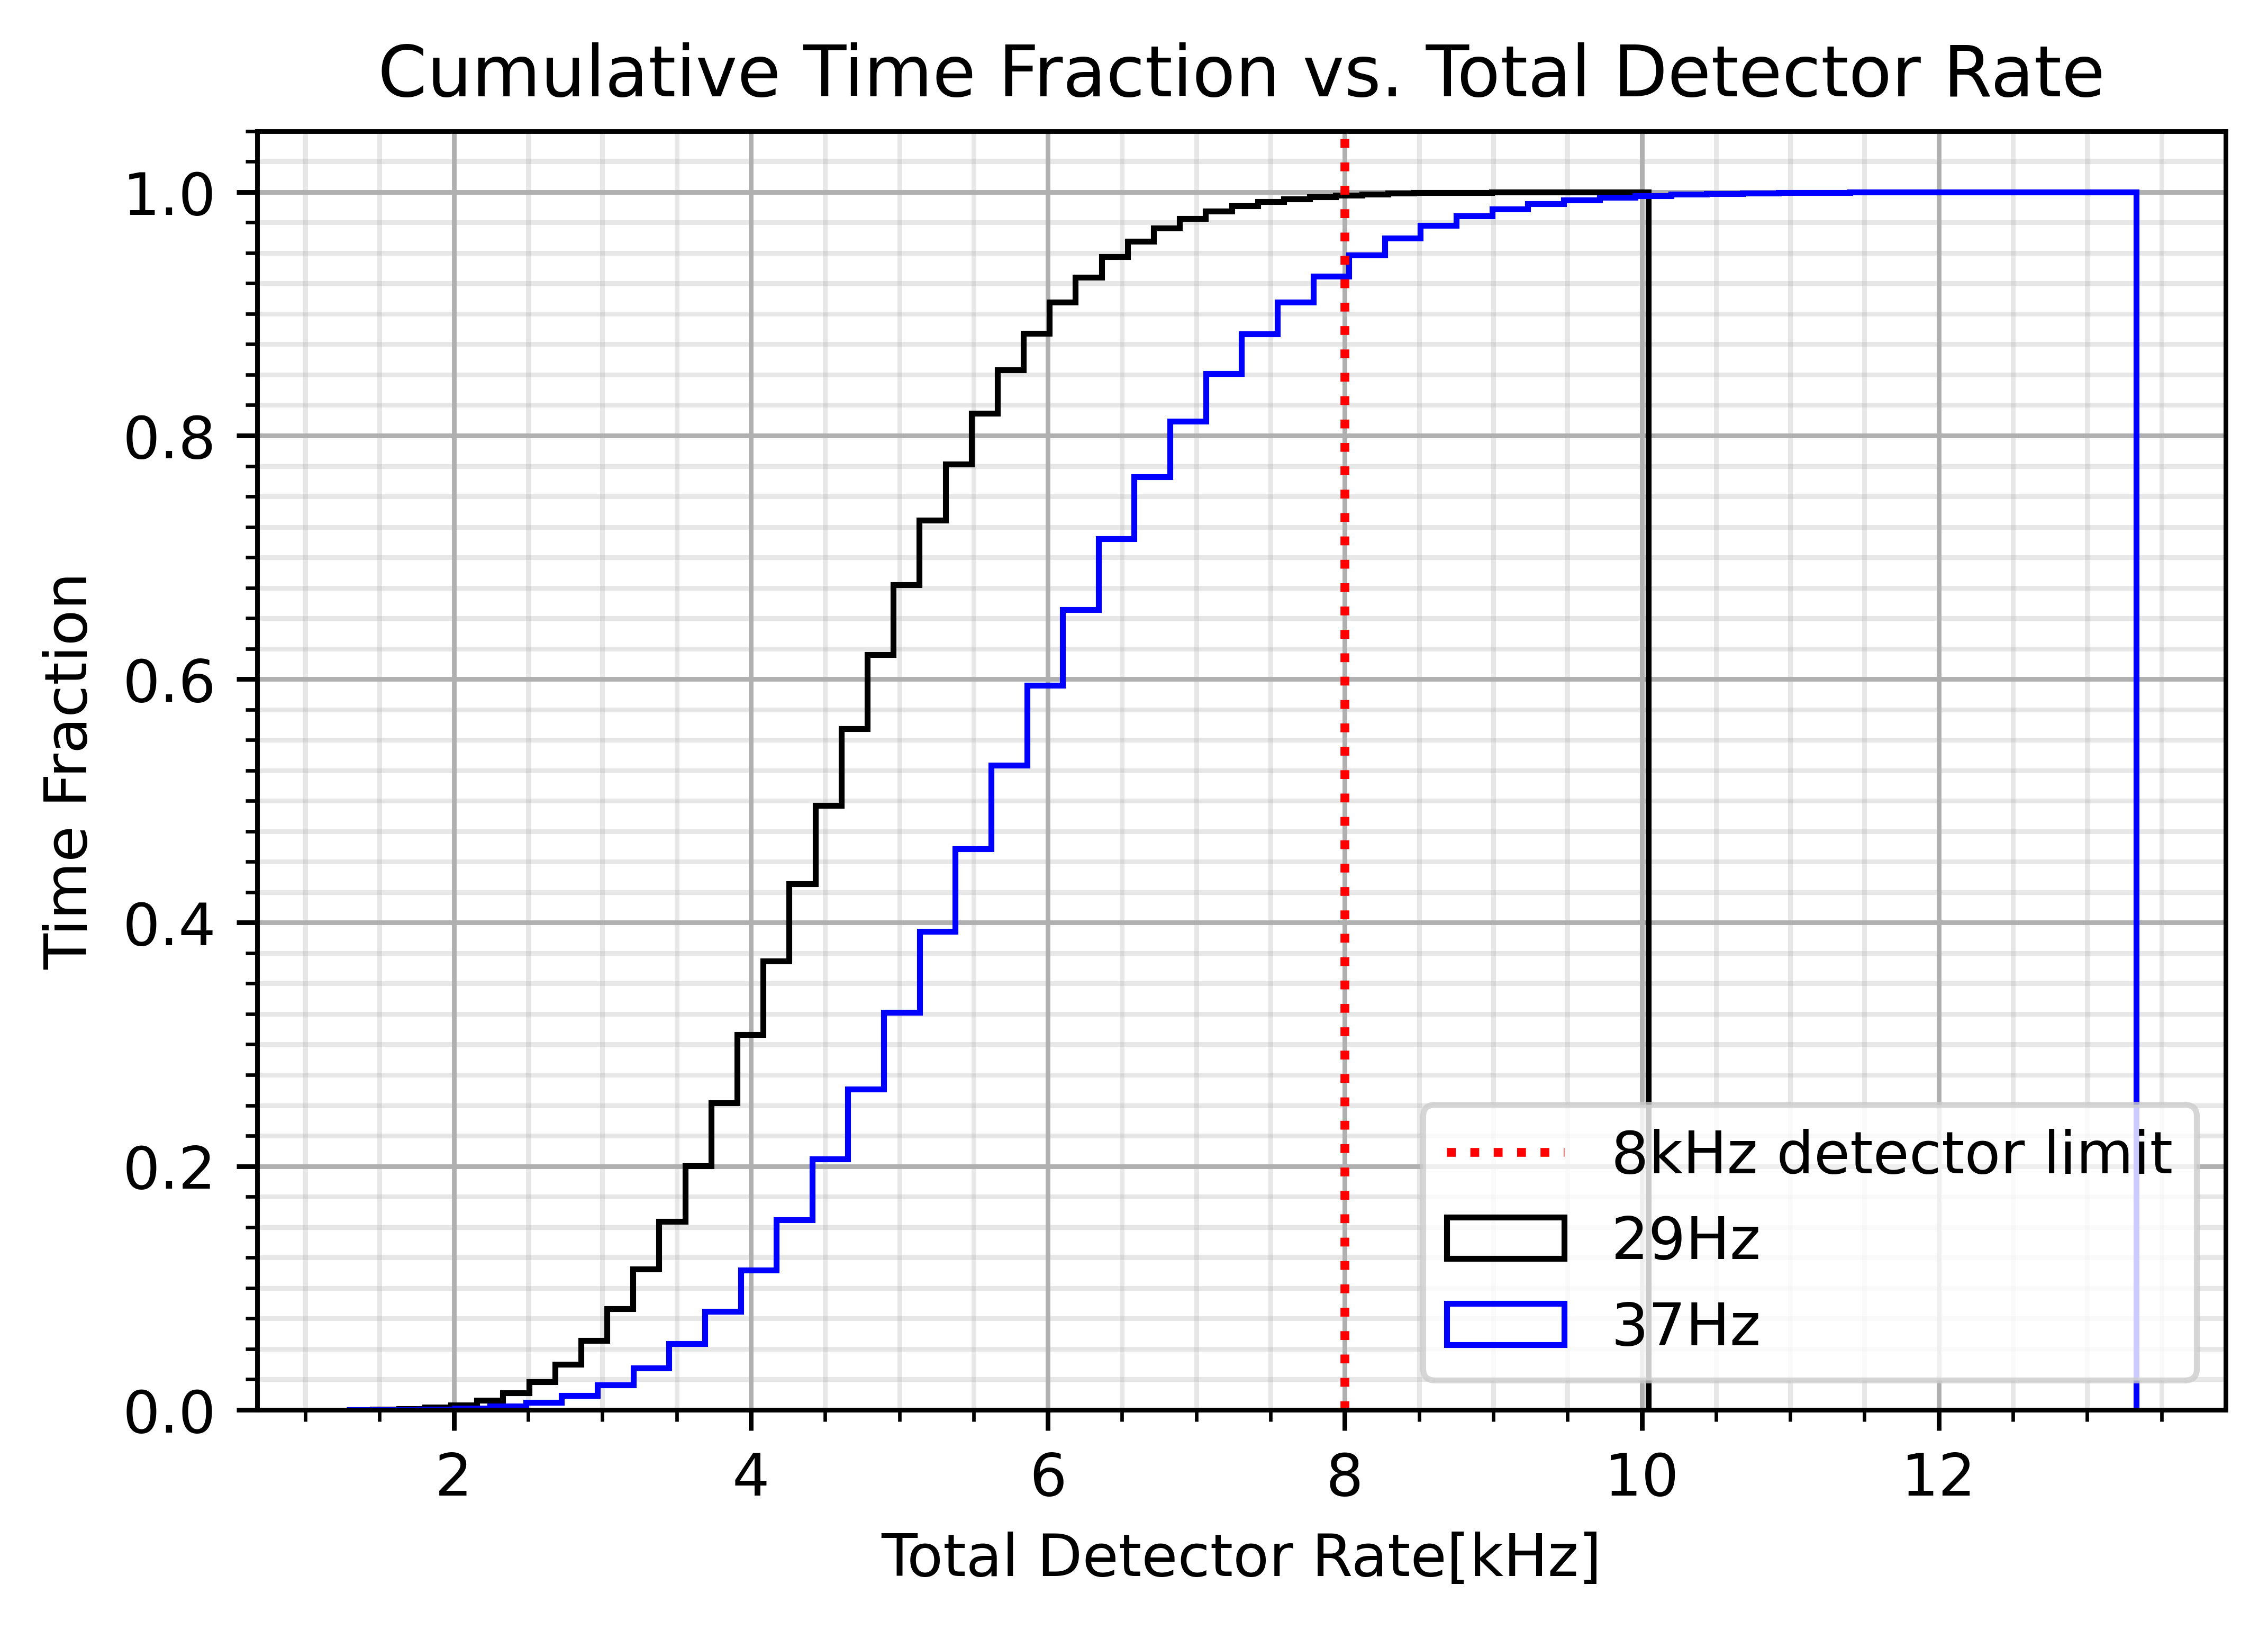

In [13]:
colors={54:'black',55:'blue'}
labels = {54:str(round(freqs[54])),55:str(round(freqs[55]))}
life_time = {54:float(),55:float()}
for i in tdr:
    plt.figure(1,dpi = 800)
    tdrc= plt.hist(tdr[i],bins=50,density=True,histtype='step',cumulative=True,
                   color = colors[i],label = labels[i] + 'Hz')
    
    for j in range(len(tdrc[1])):
        if tdrc[1][j] >= 8:
            life_time[i]=tdrc[0][j]
            print(j,tdrc[0][j],tdrc[1][j])
            break
plt.axvline(x=8,color='r',linestyle='dotted',label='8kHz detector limit')
plt.minorticks_on()
plt.gca().yaxis.set_minor_locator(MultipleLocator(.025))
plt.grid()
plt.grid(which='minor',alpha=0.3)
#plt.xscale('log')
plt.ylabel('Time Fraction')
plt.xlabel('Total Detector Rate[kHz]')
plt.title('Cumulative Time Fraction vs. Total Detector Rate')
plt.legend(loc='lower right')
plt.savefig('time_fraction_8khz.jpg',dpi = 800,bbox_inches='tight')

In [14]:
life_time

{54: 0.99832, 55: 0.9483099999999999}

In [15]:
_,freqs = trigger_rates(2,rates,time_fraction,16,True).singleDOMhalf()
for i in range(len(freqs)):
    if freqs[i] >= 2500:
        print(i,freqs[i],freqs[i-1],freqs[i-2])
        break

46 2578.6814227263294 2382.3760189263294 2210.4729620463295


## Total Detector Rate for high rates

In [16]:
%%time
tdr2 = {44:list(),45:list()}

for i in [44,45]:
    nom_dom_rate = []
    f = [j/sum(time_fraction[:i]) for j in time_fraction[:i]]
    cf = [sum(f[:j+1]) for j in range(len(f[:i]))]
    for j in rates[:i]:
        nom_dom_rate.append(trigger_rates(2,rates,time_fraction,16,True).singleDOMnominal(j))
    tdr2[i] = generate_tdr(nom_dom_rate,cf)

100%|██████████| 100000/100000 [00:28<00:00, 3483.94it/s]

CPU times: user 56.5 s, sys: 581 ms, total: 57.1 s
Wall time: 57.1 s


In [17]:
tdr2[44] = [i/1000 for i in tdr2[44]]
tdr2[45] = [i/1000 for i in tdr2[45]]

39 0.9994500000000002 500.16855903735654
35 0.9836799999999999 505.0972108054916


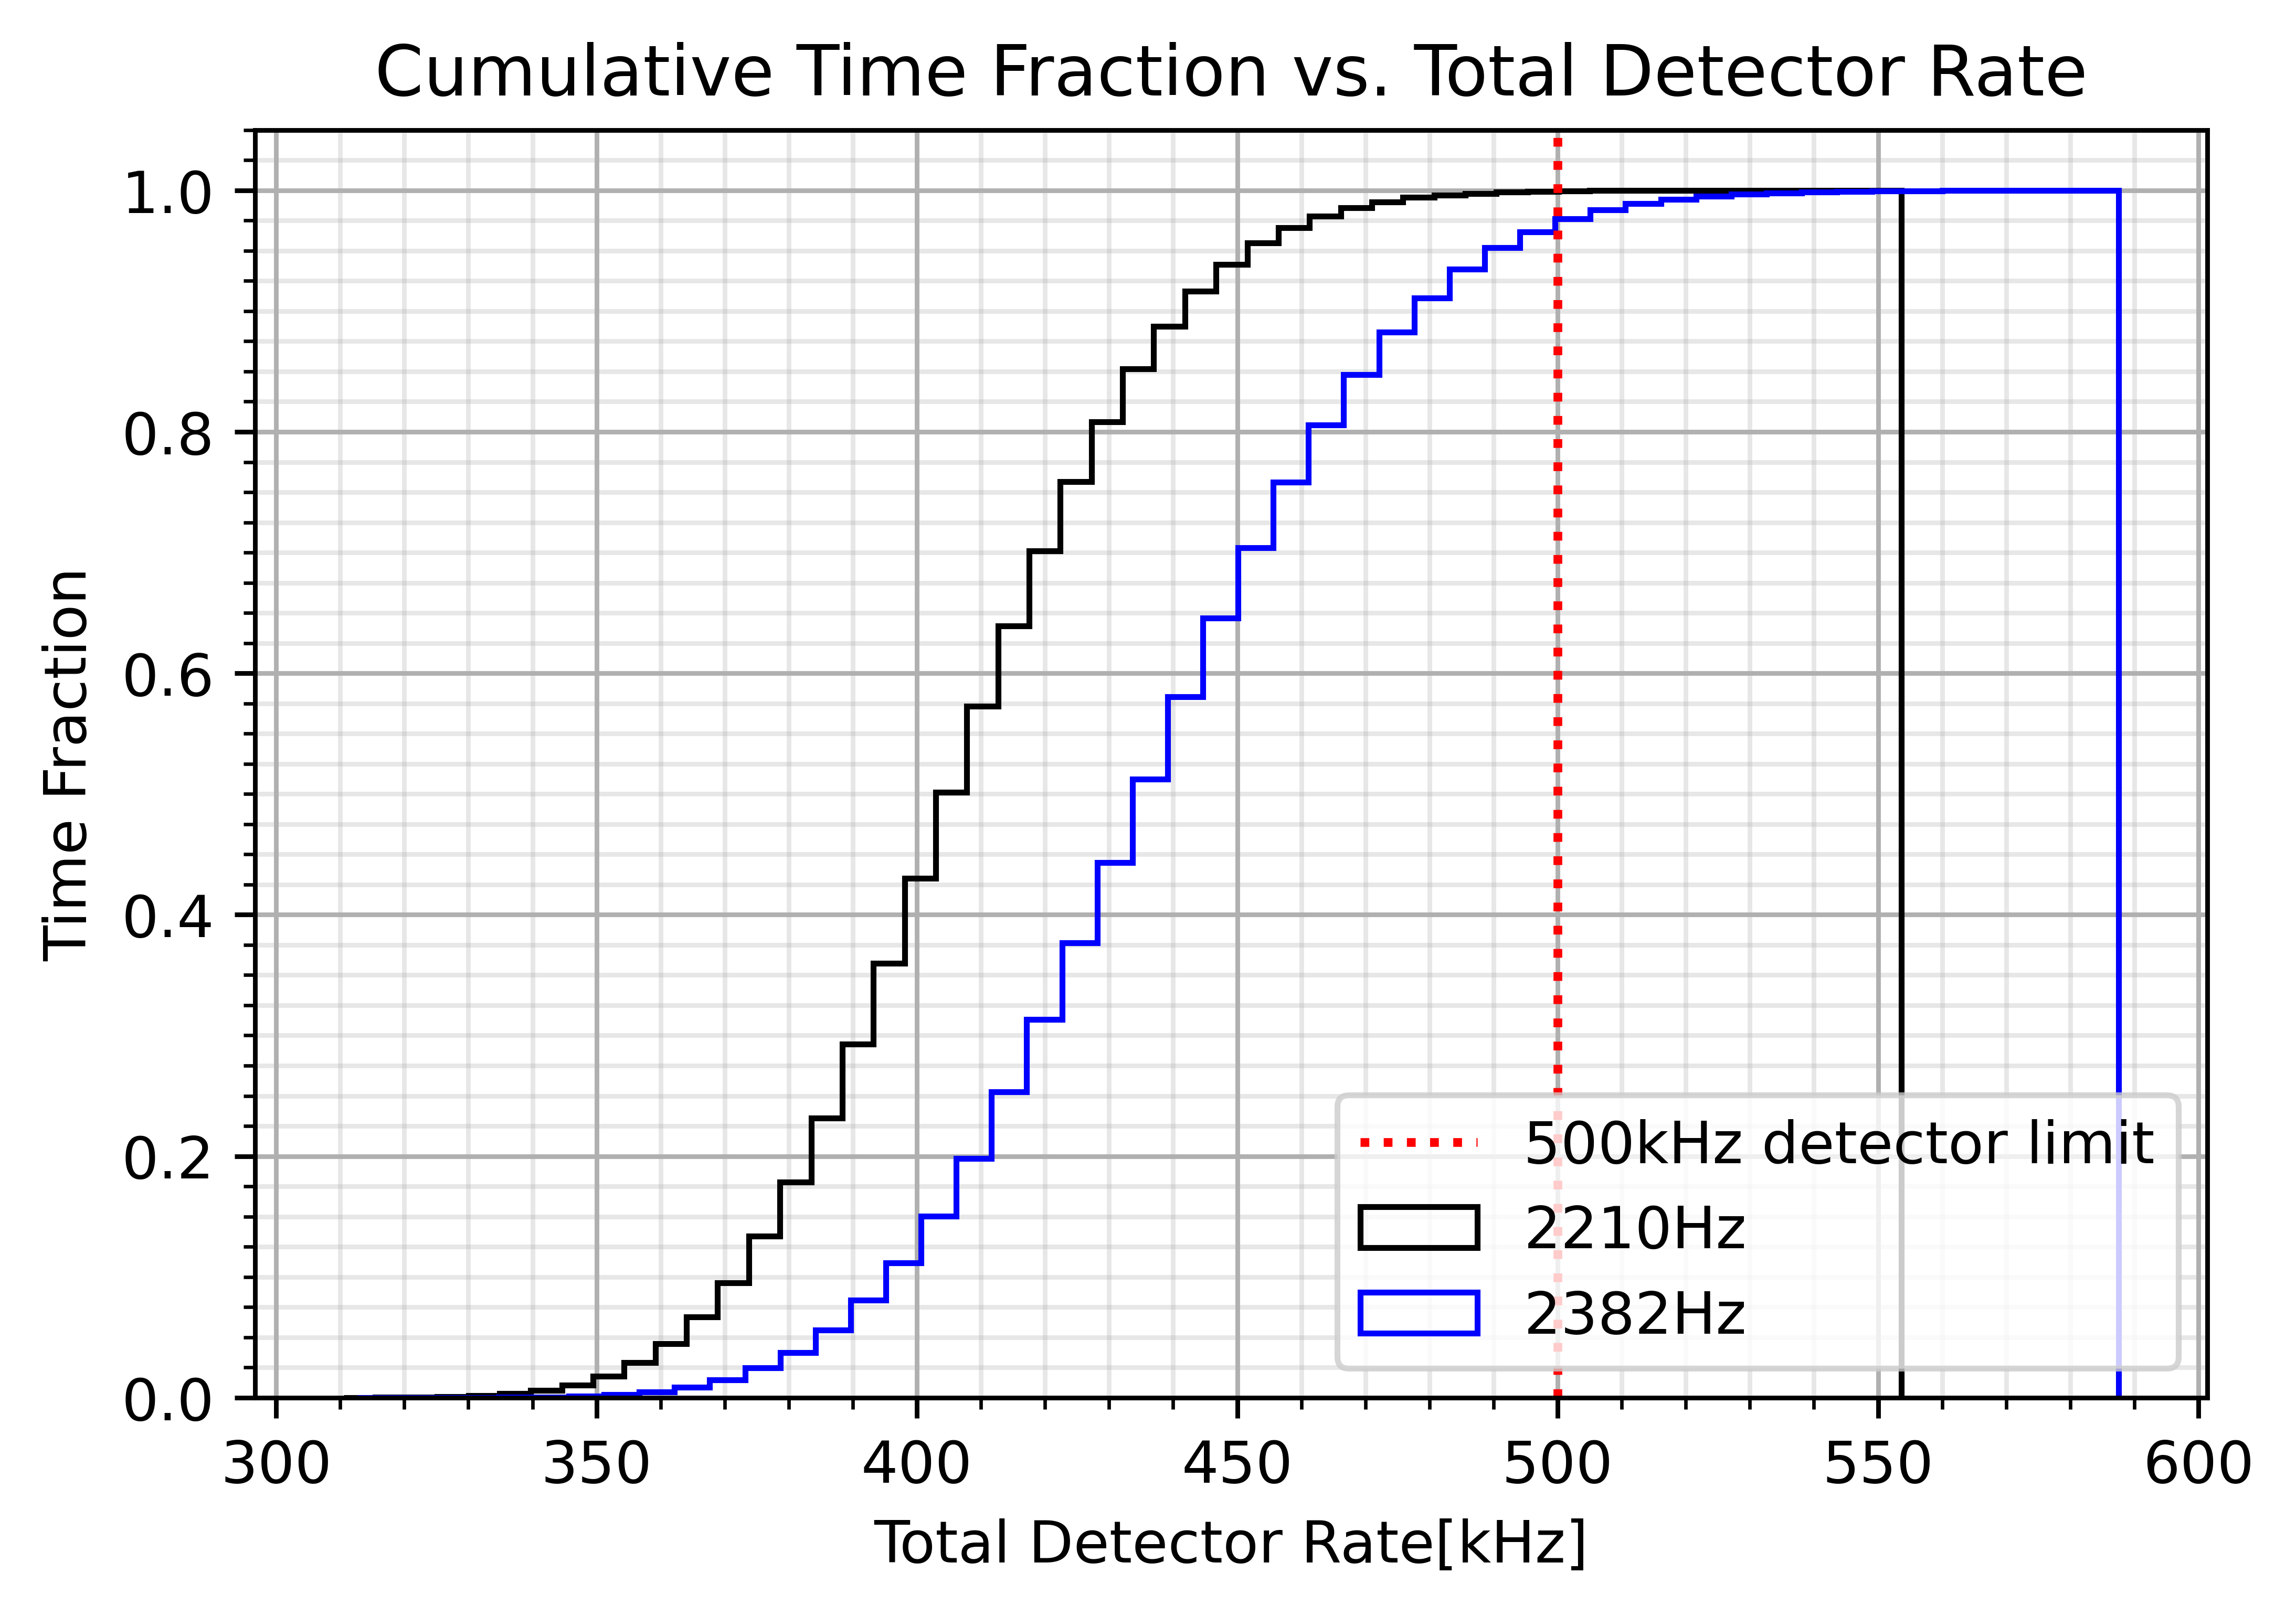

In [18]:
colors={44:'black',45:'blue'}
labels = {44:str(round(freqs[44])),45:str(round(freqs[45]))}
life_time2 = {44:float(),45:float()}
for i in tdr2:
    plt.figure(1,dpi = 800)
    tdrc= plt.hist(tdr2[i],bins=50,density=True,histtype='step',cumulative=True,
                   color = colors[i],label = labels[i] + 'Hz')
    
    for j in range(len(tdrc[1])):
        if tdrc[1][j] >= 500:
            life_time2[i]=tdrc[0][j]
            print(j,tdrc[0][j],tdrc[1][j])
            break
plt.axvline(x=500,color='r',linestyle='dotted',label='500kHz detector limit')
plt.minorticks_on()
plt.gca().yaxis.set_minor_locator(MultipleLocator(.025))
plt.grid()
plt.grid(which='minor',alpha=0.3)
#plt.xscale('log')
plt.ylabel('Time Fraction')
plt.xlabel('Total Detector Rate[kHz]')
plt.title('Cumulative Time Fraction vs. Total Detector Rate')
plt.legend(loc='lower right')
plt.savefig('time_fraction_500khz.jpg',dpi = 800,bbox_inches='tight')

## Absolute Efficiency

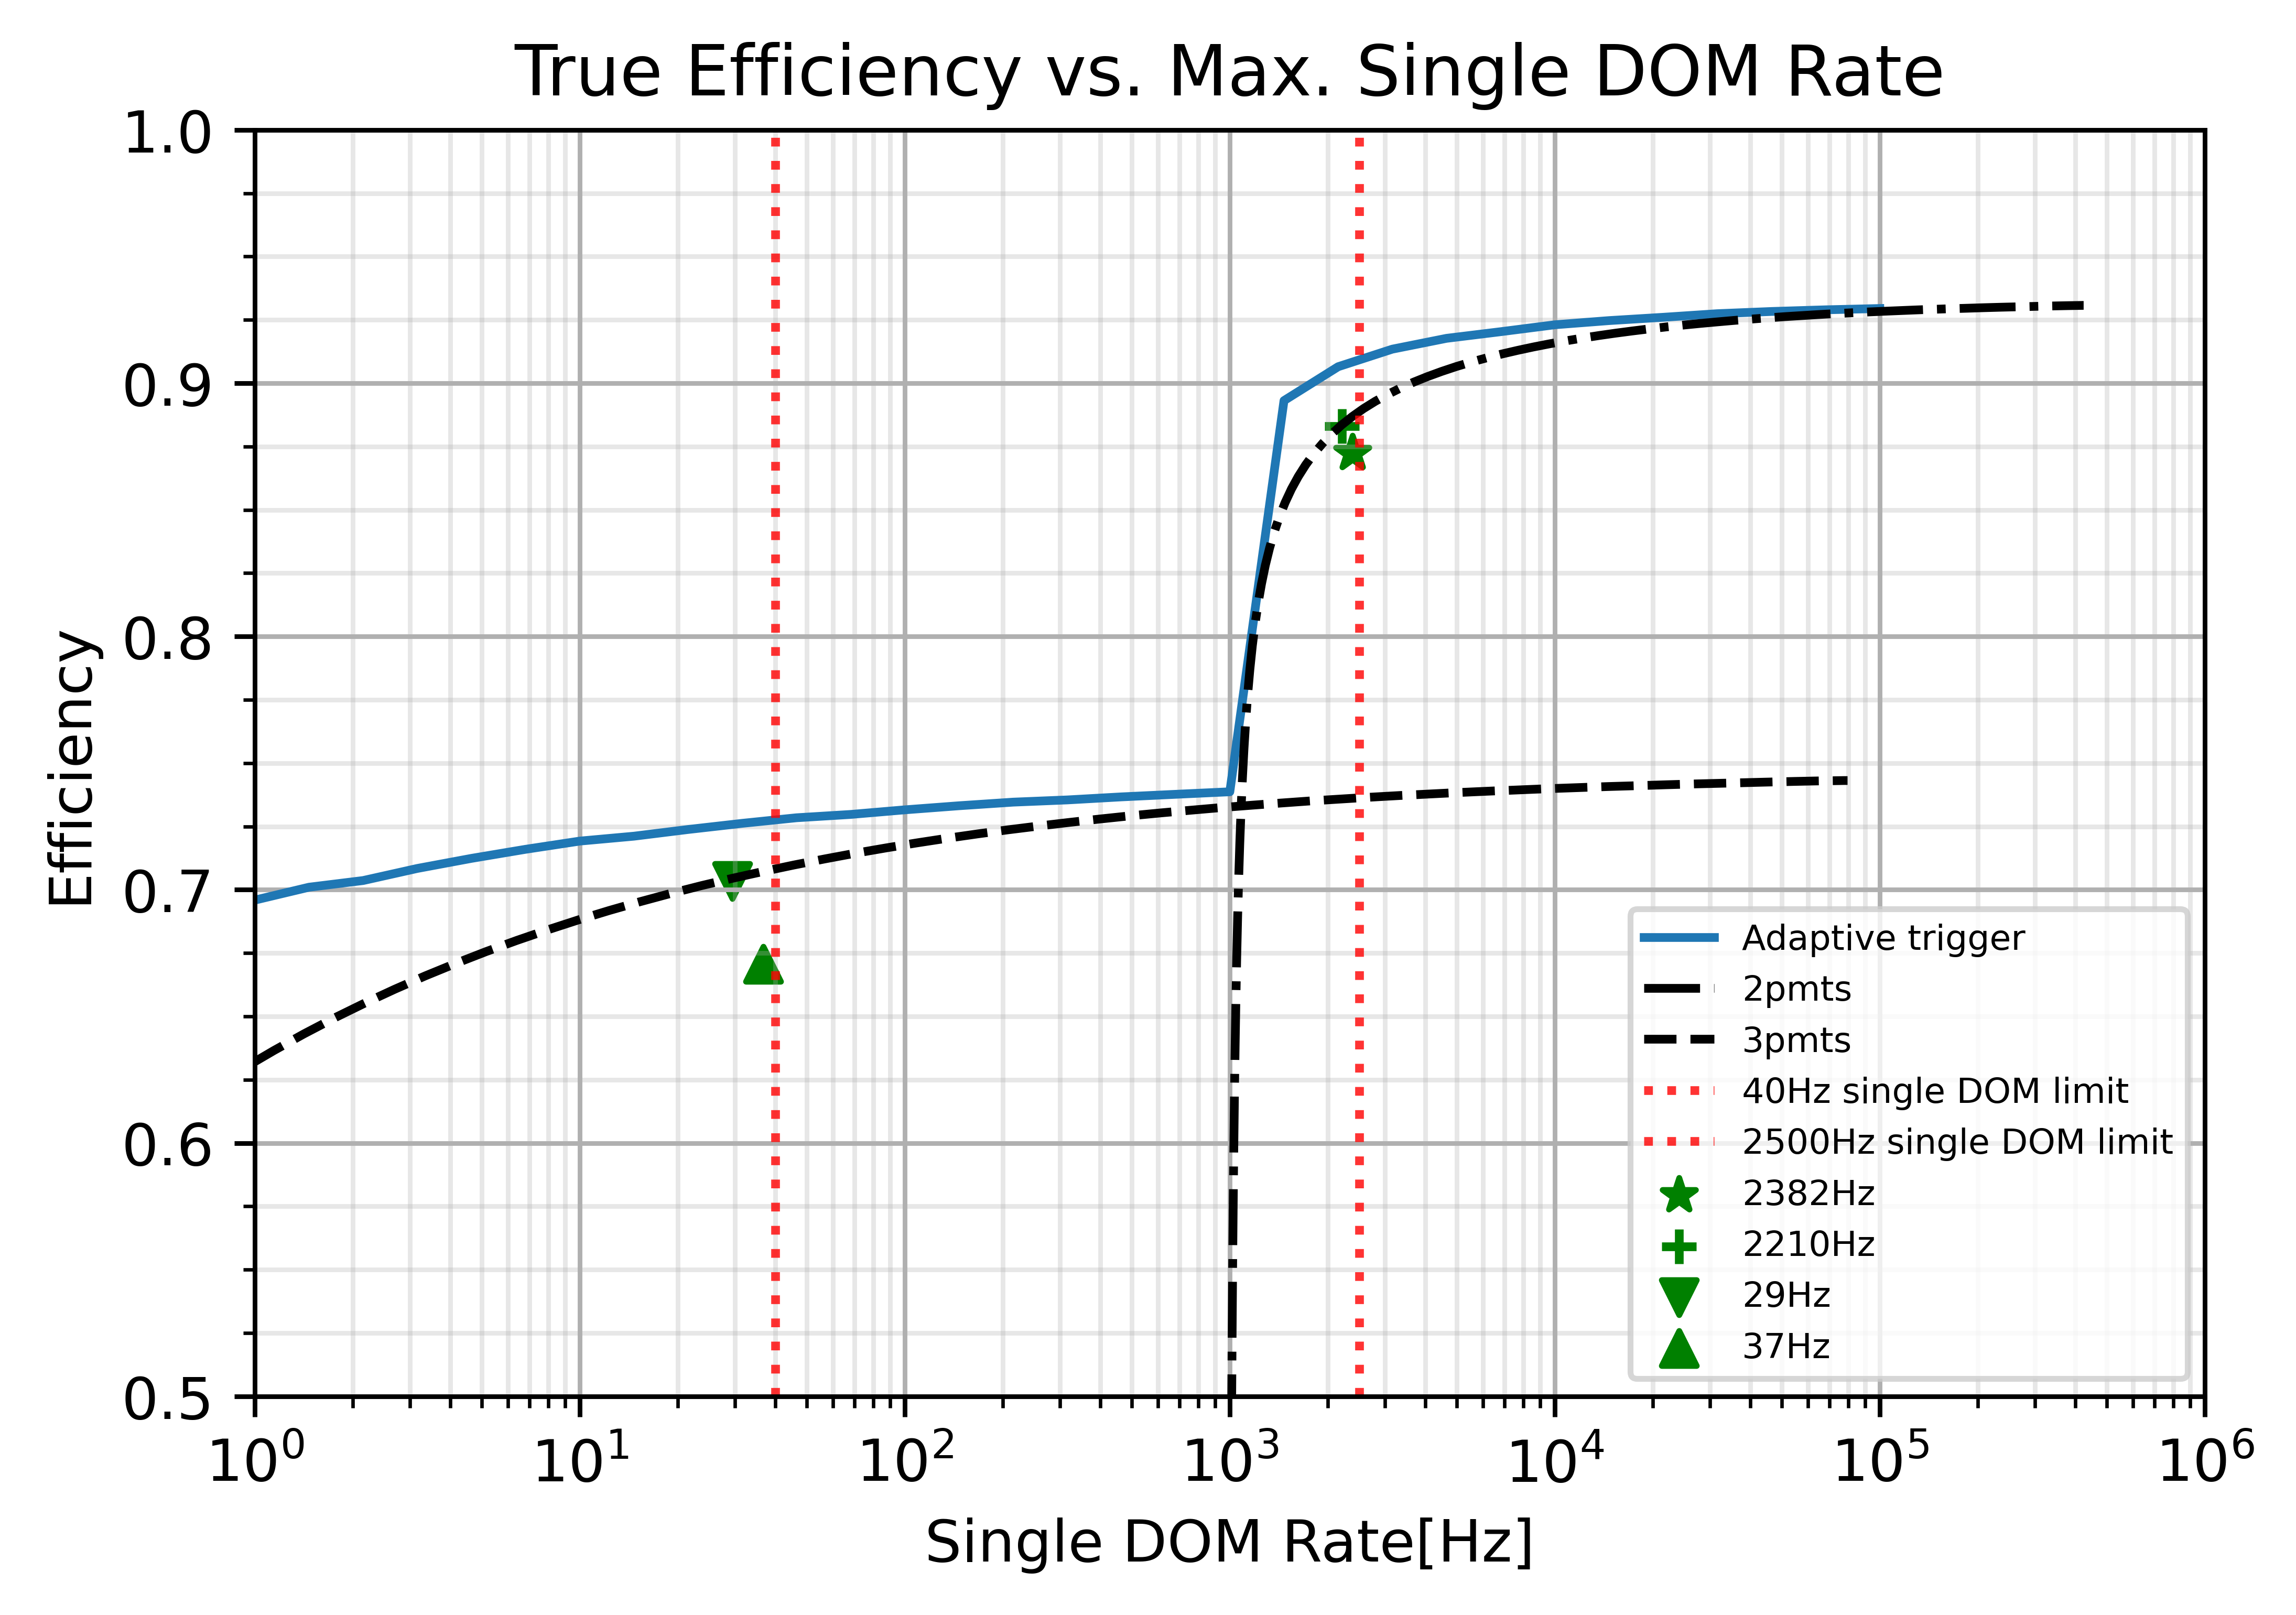

In [19]:
plt.figure(dpi=800)
plt.plot(adaptive_probability.keys(),adaptive_probability.values(),linestyle='solid',label=  'Adaptive trigger')
for n in [2,3]:
    _,freqs = trigger_rates(n,rates,time_fraction,16,True).singleDOMhalf()
    plt.plot(freqs,zero[n].values(),label=str(n)+'pmts',linestyle=linestyle[n],color='black')
    if n == 3:
        plt.scatter(freqs[54],list(zero[n].values())[54]*life_time[54],color='green',label=str(round(freqs[54]))+'Hz',marker = 'v')
        plt.scatter(freqs[55],list(zero[n].values())[55]*life_time[55],color='green',label=str(round(freqs[55]))+'Hz',marker = '^')
        #plt.scatter(freqs[56],list(zero[n].values())[56]*0.74,color='black',label=str(round(freqs[56],0))+'Hz')
    else:
        #plt.scatter(freqs[46],list(zero[2].values())[46]*0.975,color='black',label=str(round(freqs[46],0))+'Hz',marker='*')
        plt.scatter(freqs[45],list(zero[2].values())[45]*life_time2[45],color='green',label=str(round(freqs[45]))+'Hz',marker='*')
        plt.scatter(freqs[44],list(zero[2].values())[44]*life_time2[44],color='green',label=str(round(freqs[44]))+'Hz',marker='+')

plt.axvline(x=40,color='r',alpha=0.8,linestyle=':',label='40Hz single DOM limit')
plt.axvline(x=2500,color='r',alpha=0.8,linestyle=':',label='2500Hz single DOM limit')
#lt.scatter(2400,list(zero[3].values())[56]*0.74,color='black',label='40Hz')
plt.minorticks_on()
plt.gca().yaxis.set_minor_locator(MultipleLocator(.025))
plt.grid()
plt.grid(which='minor',alpha=0.3)
plt.xscale('log')
plt.ylabel('Efficiency')
plt.xlabel('Single DOM Rate[Hz]')
plt.title('True Efficiency vs. Max. Single DOM Rate')
plt.legend(fontsize=6)
plt.xlim([10e-1,10e5])
plt.ylim([.5,1])
plt.savefig('true_efficiency.jpg',dpi=800,bbox_inches='tight')